Training both agents...
Training human driver...
Training autonomous vehicle...


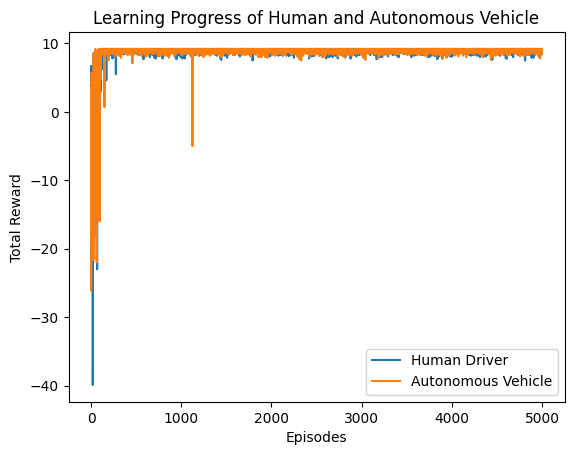


Simulation:
Human Driver's Actions: ['STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT']
Autonomous Vehicle's Actions: ['STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT', 'STEER_RIGHT']
Action Similarity: 9/9


<ipython-input-2-739e3797bbda>:155: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  human_line.set_data(human_pos, 1)
<ipython-input-2-739e3797bbda>:156: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  auto_line.set_data(auto_pos, 2)
<ipython-input-2-739e3797bbda>:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved as 'simulation.gif'


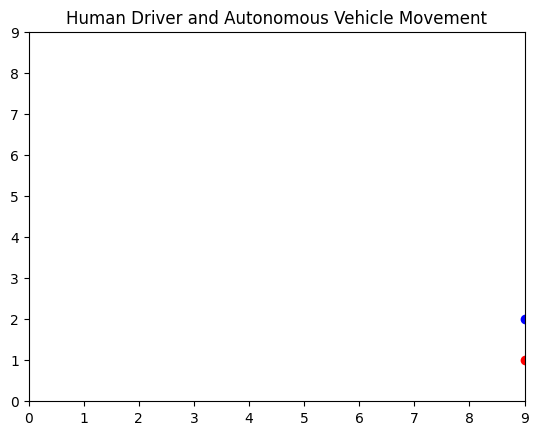

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image  # Pillow library to create GIF

# Define the environment parameters
ROAD_LENGTH = 10
GRID_SIZE = 10  # Size of the grid world
ACTIONS = ['STAY', 'ACCELERATE', 'BRAKE', 'STEER_LEFT', 'STEER_RIGHT']  # Possible actions
NUM_EPISODES = 5000
ALPHA = 0.1  # Learning rate
GAMMA = 0.9  # Discount factor
EPSILON = 0.2  # Exploration factor

# Simple environment for the autonomous vehicle
class RoadEnvironment:
    def __init__(self):
        self.length = ROAD_LENGTH
        self.grid_size = GRID_SIZE
        self.car_position = 0  # Start at the beginning of the road
        self.car_speed = 0  # Speed of the car (in units)
        self.goal_position = ROAD_LENGTH - 1  # The goal is to reach the end of the road

    def reset(self):
        self.car_position = 0
        self.car_speed = 0
        return (self.car_position, self.car_speed)

    def step(self, state, action):
        position, speed = state

        # Take the action
        if action == 'ACCELERATE':
            speed += 1
        elif action == 'BRAKE':
            speed = max(0, speed - 1)  # Speed can't be negative
        elif action == 'STEER_LEFT':
            position -= 1
        elif action == 'STEER_RIGHT':
            position += 1

        # Enforce road boundaries
        position = max(0, min(position, self.length - 1))
        position = position % self.grid_size  # Wrap around if out of bounds

        # Simulate reward (positive for reaching goal, negative for being stuck or going out of bounds)
        if position == self.goal_position:
            reward = 10  # Reached the goal
        elif position < 0 or position >= self.grid_size:
            reward = -1  # Invalid move
        else:
            reward = -0.1  # Small penalty for each step

        return (position, speed), reward

# Agent class using Q-learning to mimic human driver behavior
class Agent:
    def __init__(self, epsilon=EPSILON, alpha=ALPHA, gamma=GAMMA):
        self.q_table = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def get_q_value(self, state, action):
        if state not in self.q_table:
            self.q_table[state] = {action: 0 for action in ACTIONS}
        return self.q_table[state][action]

    def update_q_value(self, state, action, reward, next_state, next_action):
        current_q = self.get_q_value(state, action)
        future_q = self.get_q_value(next_state, next_action)
        new_q = current_q + self.alpha * (reward + self.gamma * future_q - current_q)
        self.q_table[state][action] = new_q

    def choose_action(self, state, is_exploring=True):
        if is_exploring and random.uniform(0, 1) < self.epsilon:
            return random.choice(ACTIONS)
        else:
            q_values = [self.get_q_value(state, action) for action in ACTIONS]
            max_q = max(q_values)
            best_actions = [action for action, q in zip(ACTIONS, q_values) if q == max_q]
            return random.choice(best_actions)

    def train(self, environment, num_episodes=NUM_EPISODES, is_exploring=True):
        rewards = []
        for episode in range(num_episodes):
            state = environment.reset()
            action = self.choose_action(state, is_exploring)
            total_reward = 0

            while state[0] != environment.goal_position:
                next_state, reward = environment.step(state, action)
                next_action = self.choose_action(next_state, is_exploring)
                self.update_q_value(state, action, reward, next_state, next_action)
                state, action = next_state, next_action
                total_reward += reward

            rewards.append(total_reward)
        return rewards

# Simulating Autonomous Vehicle Learning from Human Driver
class AutonomousVehicleSimulation:
    def __init__(self):
        self.environment = RoadEnvironment()
        self.human_driver = Agent()
        self.autonomous_vehicle = Agent()

    def train_agents(self):
        # Train the human driver (the "captor")
        print("Training human driver...")
        self.human_rewards = self.human_driver.train(self.environment, num_episodes=NUM_EPISODES, is_exploring=True)

        # Now, the autonomous vehicle (the "captive") learns from the human driver
        print("Training autonomous vehicle...")
        self.auto_rewards = self.autonomous_vehicle.train(self.environment, num_episodes=NUM_EPISODES, is_exploring=True)

    def plot_learning_progress(self):
        plt.plot(self.human_rewards, label='Human Driver')
        plt.plot(self.auto_rewards, label='Autonomous Vehicle')
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.legend()
        plt.title('Learning Progress of Human and Autonomous Vehicle')
        plt.show()

    def generate_gif(self, actions_human, actions_auto):
        frames = []
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.environment.grid_size - 1)
        ax.set_ylim(0, self.environment.grid_size - 1)
        ax.set_title("Human Driver and Autonomous Vehicle Movement")

        human_pos = 0
        auto_pos = 0
        human_line, = ax.plot([], [], 'ro', label='Human Driver')
        auto_line, = ax.plot([], [], 'bo', label='Autonomous Vehicle')

        def update(frame):
            nonlocal human_pos, auto_pos
            # Update positions based on actions
            if frame < len(actions_human):
                if actions_human[frame] == 'STEER_LEFT':
                    human_pos -= 1
                elif actions_human[frame] == 'STEER_RIGHT':
                    human_pos += 1
                human_pos = max(0, min(human_pos, self.environment.grid_size - 1))

            if frame < len(actions_auto):
                if actions_auto[frame] == 'STEER_LEFT':
                    auto_pos -= 1
                elif actions_auto[frame] == 'STEER_RIGHT':
                    auto_pos += 1
                auto_pos = max(0, min(auto_pos, self.environment.grid_size - 1))

            human_line.set_data(human_pos, 1)
            auto_line.set_data(auto_pos, 2)

            # Save the current frame to a list
            plt.draw()
            buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            buf = buf.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frame_image = Image.fromarray(buf)
            frames.append(frame_image)

        # Update frames for each action
        for frame in range(max(len(actions_human), len(actions_auto))):
            update(frame)

        # Save frames as a GIF using Pillow
        frames[0].save('simulation.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)
        print("GIF saved as 'simulation.gif'")

    def simulate(self):
        # After training, evaluate the performance of both agents
        state_human = self.environment.reset()
        state_auto = self.environment.reset()
        actions_human = []
        actions_auto = []

        while state_human[0] != self.environment.goal_position:
            action_human = self.human_driver.choose_action(state_human, is_exploring=False)
            state_human, _ = self.environment.step(state_human, action_human)
            actions_human.append(action_human)

            action_auto = self.autonomous_vehicle.choose_action(state_auto, is_exploring=False)
            state_auto, _ = self.environment.step(state_auto, action_auto)
            actions_auto.append(action_auto)

        # Print actions and evaluate similarity
        print(f"Human Driver's Actions: {actions_human}")
        print(f"Autonomous Vehicle's Actions: {actions_auto}")
        print(f"Action Similarity: {sum([1 for a, b in zip(actions_human, actions_auto) if a == b])}/{len(actions_human)}")

        # Generate a road visualization GIF
        self.generate_gif(actions_human, actions_auto)

    def run(self):
        print("Training both agents...")
        self.train_agents()
        self.plot_learning_progress()
        print("\nSimulation:")
        self.simulate()

# Running the simulation
if __name__ == "__main__":
    simulation = AutonomousVehicleSimulation()
    simulation.run()
